[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ZuchniakK/CryptoDataProcessing/blob/main/6_complete_use.ipynb)

### In this notebook, I collect all the previously presented elements together. You can use this notebook as a standalone part that shows how to download and process a dataset and how to create a data batch generator based on it. However, in order to modify individual parameters and better understand the entire data analysis process behind this project, I encourage you to track all notebooks.

In [1]:
from datetime import date
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from crypto_data import DataGenerator, GeneratorTester, OHLCDataSet

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 16]

## building the dateset

We start by defining our dataset

In [3]:
ods = OHLCDataSet(
    pairs=[("eth", "usdt"), ("btc", "usdt"), ("doge", "usdt")],
    start_date=date(2022, 3, 1),
    end_date=date(2022, 4, 30),
    train_end=date(2022, 4, 1),
    ohlc_intervals=[10, 20, 60, 120],
    multithreading=True,
    keep_unchanged_df=True,
    transform_mode="mix",
    base_time_offset=pd.tseries.offsets.Minute(),
    columns=None,
)

Then we start data download and preprocessing. In the next cell, we will store the processed data. This step takes the most time, with the settings below about 15 minutes, you can also download ready-made numpy tables and metadata and immediately go to the data generation stage

In [ ]:
# download data and prepare dataset
res = ods.make_dataset()

In [5]:
pprint(ods.timing)

{'add_time_features_time': 0.08798745699823485,
 'clear_time': 0.25629752399981953,
 'columns_organizing_time': 0.0003813679977611173,
 'drop_monotonic_time': 0.17022228199857636,
 'drop_unused_time': 0.11132274999908987,
 'get_columns_time': 2.0414830499976233,
 'get_price_columns_time': 0.7628062949988816,
 'get_price_std_time': 8.32229860499865,
 'load_time': 266.8842284120001,
 'normalize_candle_time': 0.5367904339982488,
 'normalize_other_time': 24.664569450000272,
 'remove_no_variance_time': 3.2351490719993308,
 'remove_redundant_features_time': 8.449555074999807,
 'whole_process_time': 314.84771175100104}


In [6]:
# save whole instance
ods.save("instance")
# save metadata
ods.save_metadata("metadata")
# convert dataframes to numpy arrays and save it ~ 19MB, for this example
ods.save_arrays("arrays")
# compressed variant ~ 12MB, for this example
ods.save_compressed_arrays("arrays_compressed")

## Batch data generator

once we have a dataset created, we can load it and start sampling

In [7]:
data_generator = DataGenerator(metadata="metadata.pkl", arrays="arrays.npz")

It is also worth checking the correctness of the generated dataset

In [14]:
gt = GeneratorTester(data_generator)
errors = gt.test_ohlc_data(n=100, batch_size=64)
print(f"errors: {errors}")

batch size: 64, n tests: 100, batch generation took: 0.2760538820111833, testing took: 0.5364511150110047
errors: {'open': 0, 'high': 0, 'low': 0, 'close': 0}


In [15]:
batch_size = 32

train_gen = data_generator.get_train_generator(
    price_normalize="pct_change",
    price_normalize_column="close",
    batch_size=batch_size,
    seed=123,
)
val_gen = data_generator.get_val_generator(
    price_normalize="pct_change",
    price_normalize_column="close",
    batch_size=batch_size,
)
test_gen = data_generator.get_test_generator(
    price_normalize="pct_change",
    price_normalize_column="close",
    batch_size=batch_size,
)

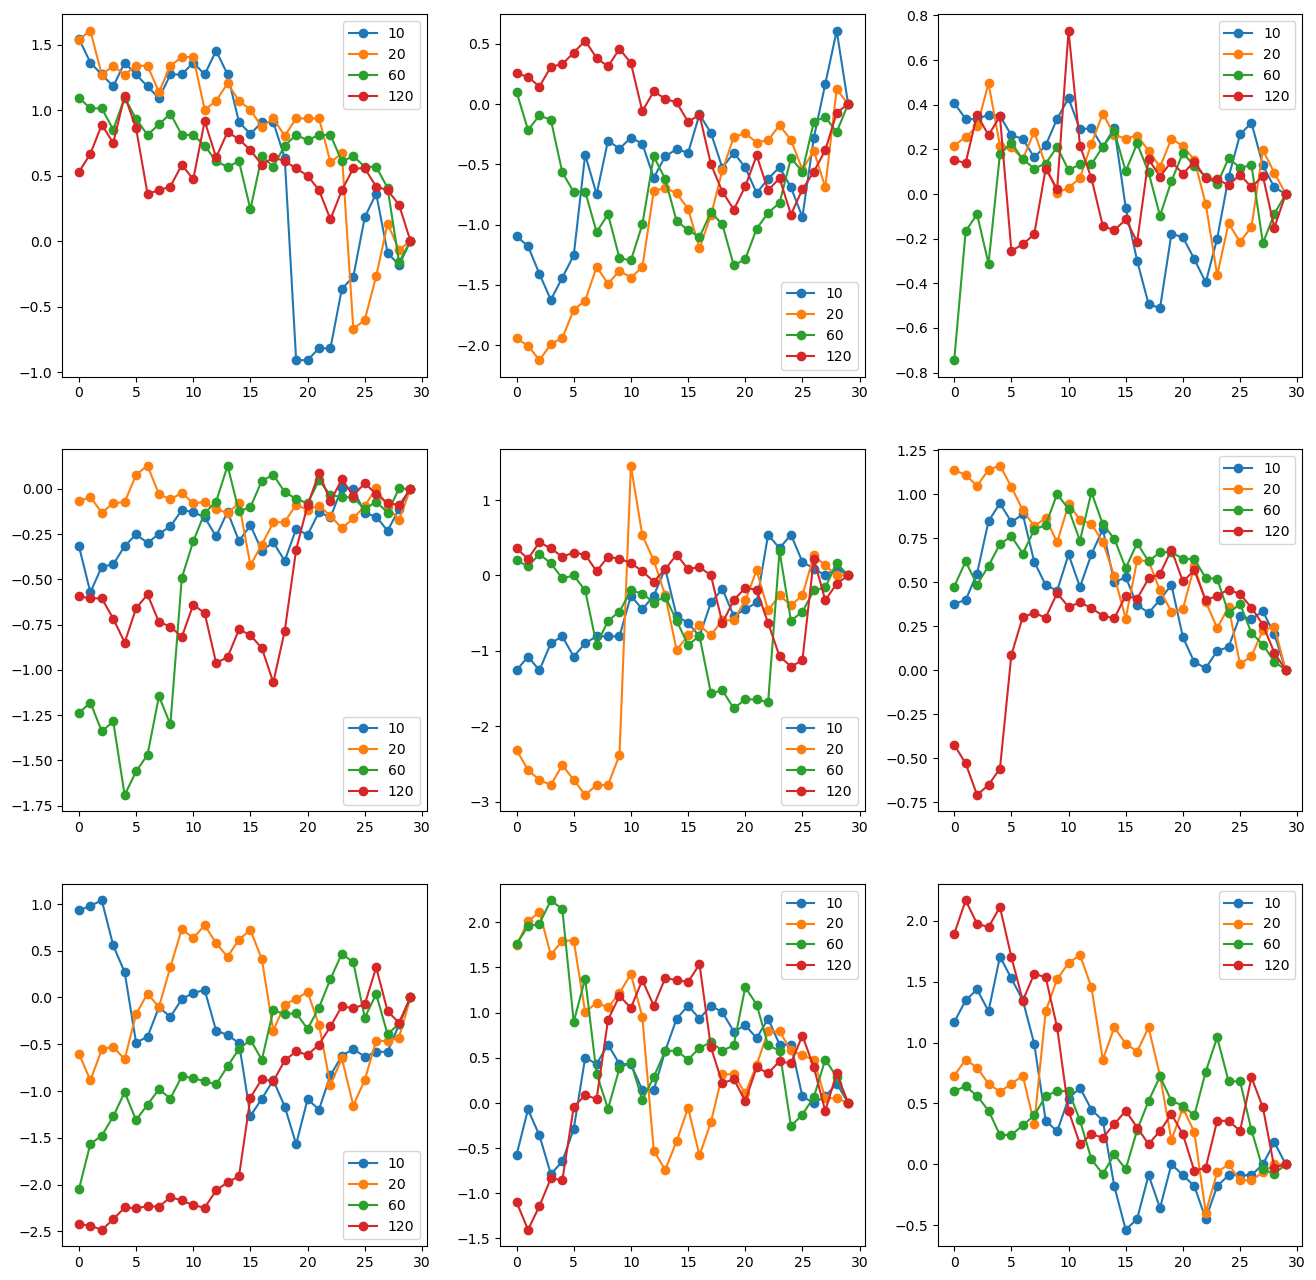

In [16]:
x_batch_train, y_batch_train = next(train_gen)

close_idx = np.where(data_generator.columns_order == "close")[0][0]
fig, axs = plt.subplots(3, 3)
for i, ax in enumerate(fig.axes):
    for interval_id, x in enumerate(x_batch_train):
        ax.plot(
            x[i, :, close_idx],
            linestyle="-",
            marker="o",
            label=data_generator.ohlc_intervals[interval_id],
        )
    ax.legend()

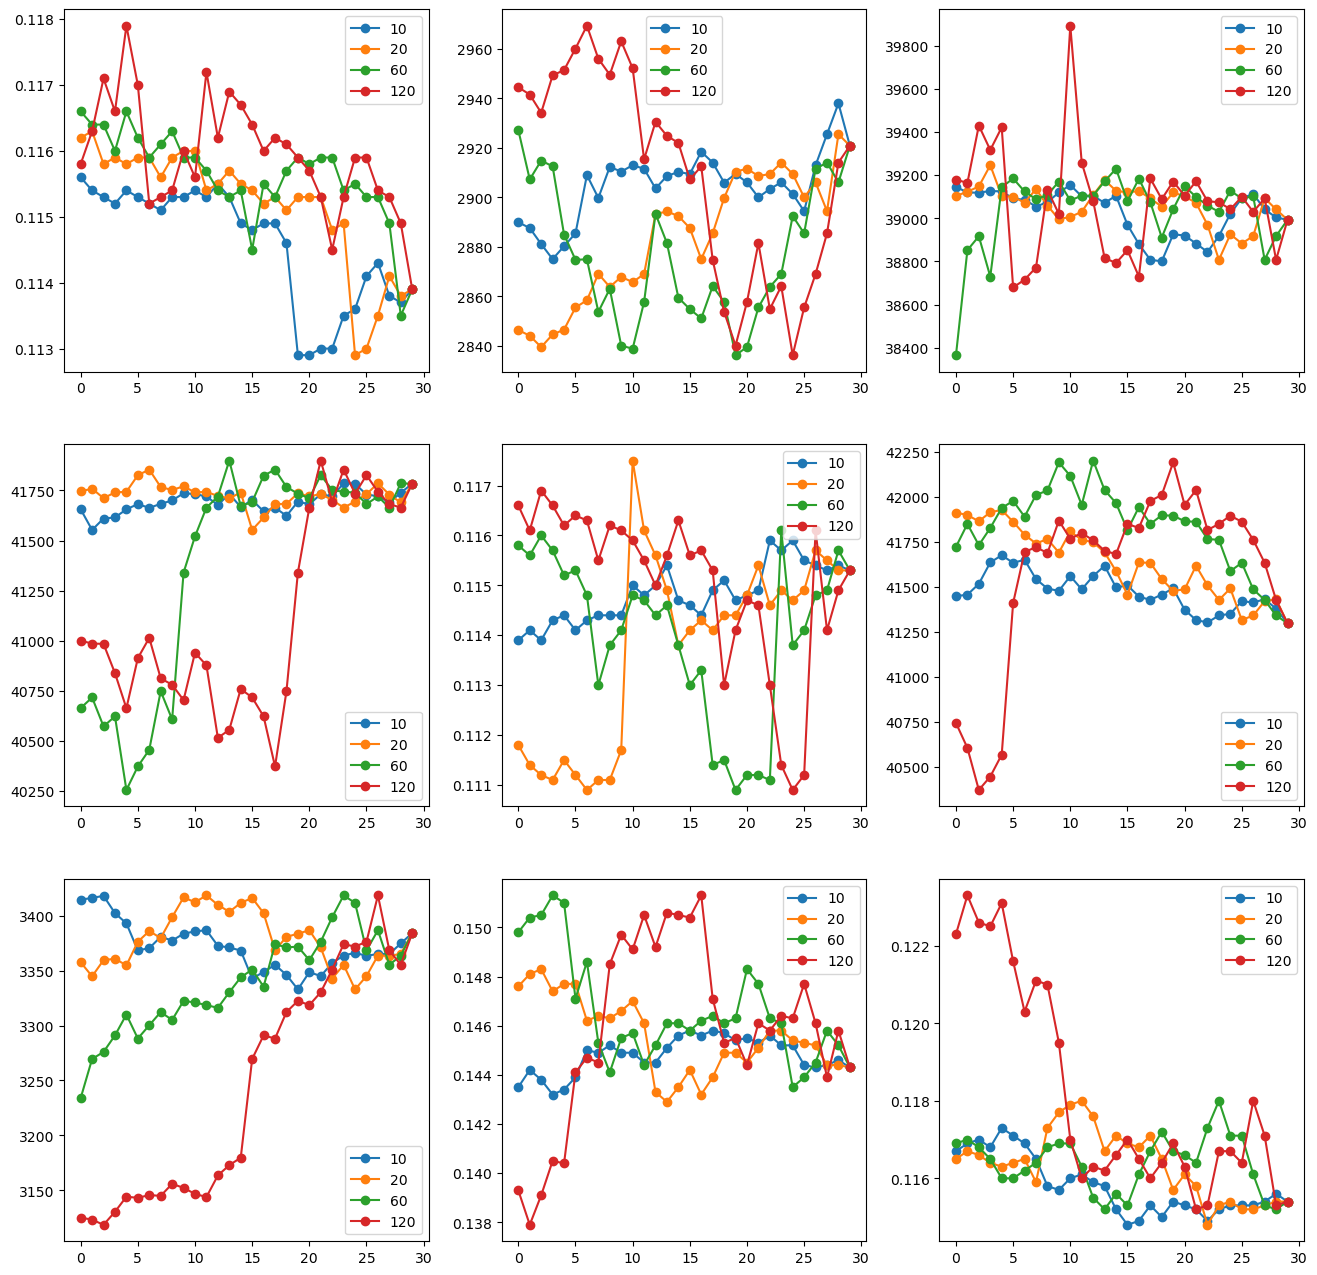

In [17]:
train_gen = data_generator.get_train_generator(
    price_normalize=False, price_normalize_column="close", batch_size=32, seed=123
)
x_batch_train, y_batch_train = next(train_gen)

close_idx = np.where(data_generator.columns_order == "close")[0][0]
fig, axs = plt.subplots(3, 3)
for i, ax in enumerate(fig.axes):
    for interval_id, x in enumerate(x_batch_train):
        ax.plot(
            x[i, :, close_idx],
            linestyle="-",
            marker="o",
            label=data_generator.ohlc_intervals[interval_id],
        )
    ax.legend()